In [1]:
using MyBioTools.FluTools
using Plots
pyplot()
using FastaIO
using Dates
using LaTeXStrings
using BioSequences
using StatsBase
using CurveFit

┌ Info: Recompiling stale cache file /home/pierrebc/.julia/compiled/v1.1/CurveFit/yfYeb.ji for CurveFit [5a033b19-8c74-5913-a970-47c3779ef25c]
└ @ Base loading.jl:1184
┌ Warning: /home/pierrebc/.julia/packages/Plots/WwFyB/src/Plots.jl/ is not an existing directory, Revise is not watching
└ @ Revise /home/pierrebc/.julia/packages/Revise/0KQ7U/src/Revise.jl:485


# General orders of magnitude

In [2]:
sp = FluTools.StrainPop("../data/aligned_h3n2_ha.fasta", seqtype=:nt, missingdates = true, segment="ha", strain="h3n2");

Translating sequences...
Reading alignment...


### Number of strains
How many strains per year do I have? 
And if I count only those for which we have a month, how many are left? 

In [3]:
peryear = Dict()
peryear_wm = Dict()
for s in sp.strains
    if !ismissing(s.year)
        peryear[s.year] = get(peryear, s.year, 0) + 1
        if !ismissing(s.month)
            peryear_wm[s.year] = get(peryear_wm, s.year, 0) + 1
        end
    end
end

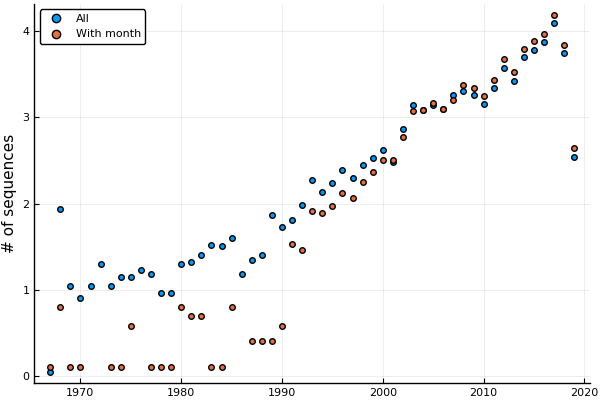

In [4]:
scatter(Float64.(collect(keys(peryear))), log10.(Float64.(collect(values(peryear))) .+0.1), ylabel = "# of sequences", label="All")
scatter!(Float64.(collect(keys(peryear_wm))), Float64.(log10.(collect(values(peryear_wm))) .+0.1), label="With month")

### By region

In [5]:
spr = Dict()
for r in FluTools.nextstrain_regions
    spr[r] = FluTools.StrainPop(strains = FluTools.filterstrains(sp, regions = [r]));
end

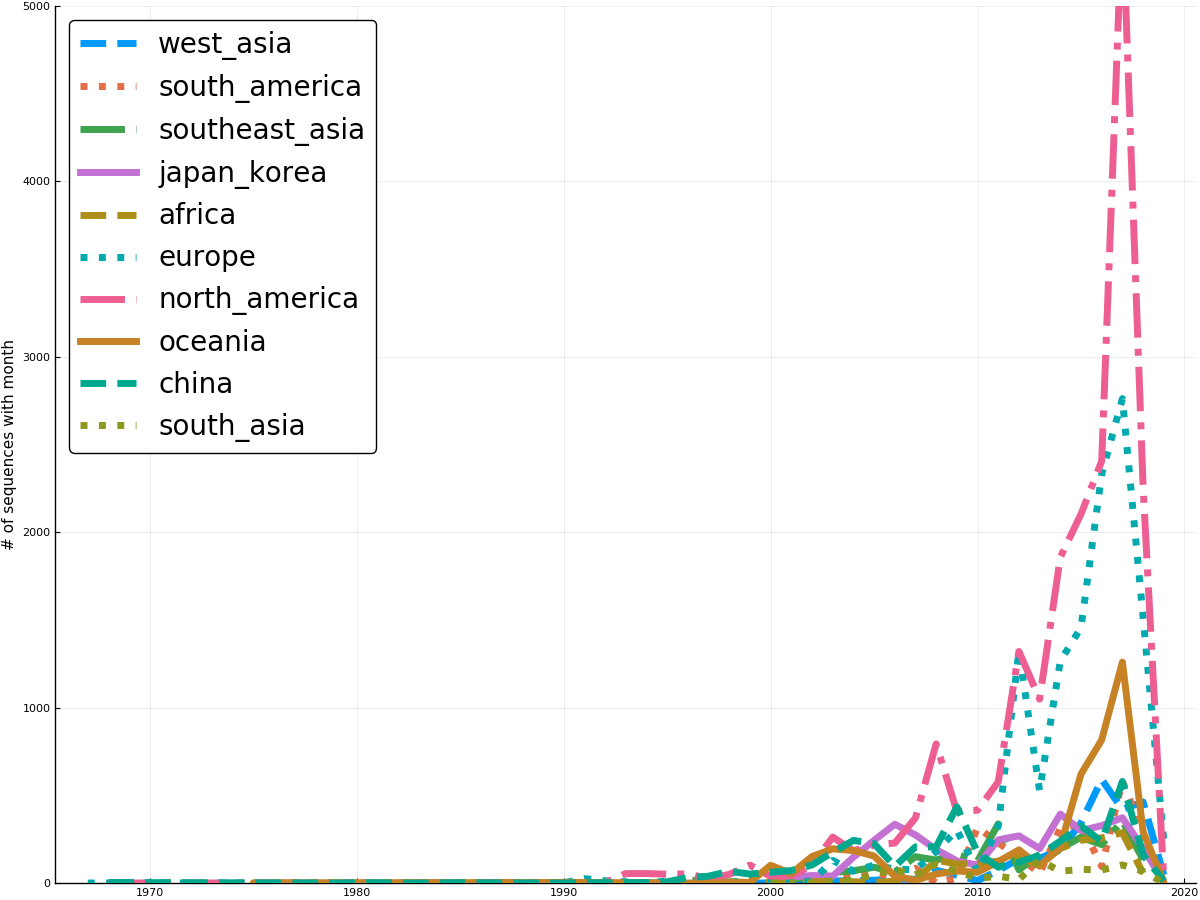

In [6]:
#
styles = filter((s->begin
                s in Plots.supported_styles()
            end), [:solid, :dash, :dot, :dashdot, :dashdotdot])
styles = reshape(styles, 1, length(styles))
#
p = plot(size=(1200,900), legendfontsize=20)
for (i,(r,sp)) in enumerate(spr)
    peryear_wm = Dict()
    for s in sp.strains
        if !ismissing(s.month)
            peryear_wm[s.year] = get(peryear_wm, s.year, 0) + 1
        end
    end
    tmp = sortperm(collect(keys(peryear_wm)))
    x = Float64.(collect(keys(peryear_wm)))[tmp]
    y = Float64.(collect(values(peryear_wm)))[tmp]
    plot!(p, x, y, label="$r", line=(5, styles[mod(i,4)+1]))
end
plot!(p, ylim=(0,5000), ylabel="# of sequences with month")

# Frequency trajectories

I'll use only strains with a complete date in the following.
Given numbers above, only those later than 1995 will be used. 

In [7]:
# Reading data
@time sp = FluTools.StrainPop("../data/aligned_h3n2_ha.fasta", missingdates = false, seqtype=:nt, segment="ha", strain="h3n2");
FluTools.bin_by_date!(sp, start = Date(1995));
L = length(sp.strains[1].aa_seq);

Translating sequences...
Reading alignment...
 25.629611 seconds (145.53 M allocations: 4.170 GiB, 59.09% gc time)


In [8]:
# History of all positions
ph = Array{FluTools.PosEvo,1}(undef,L)
for i in 1:L
    print("$i       \r")
    ph[i] = FluTools.positions_history(i, sp)
end

## Conditioning on value of frequency

In [9]:
alphabins = 0.1:0.1:0.9
alphabins_ = [(x,0.05) for x in alphabins];


In [10]:
all_traj = FluTools.all_trajectories(ph, keep_unfinished=false)
all_traj = FluTools.previous_state_condition(all_traj, :lost)
all_traj = FluTools.population_size_condition(all_traj, 10)
freqtraj_cf = Dict()
for (α,dα) in alphabins_
    freqtraj_cf[α] = FluTools.frequency_condition(all_traj, α, dα=dα)
#     for traj in freqtraj_cf[α]
#         FluTools.compute_derivative!(traj)
#     end
end

In [9]:
freqtraj_cf = Dict()
for α in 0.1:0.1:0.9
    freqtraj_cf[α] = FluTools.frequency_condition(ph, α, filter_duplicates=false);
end

MethodError: MethodError: no method matching frequency_condition(::Array{MyBioTools.FluTools.PosEvo,1}, ::Float64; filter_duplicates=false)
Closest candidates are:
  frequency_condition(!Matched::Array{MyBioTools.FluTools.FrequencyTraj,1}, ::Any; dα, shift_time) at /home/pierrebc/Documents/BaleLabo/Code/MyTools/MyBioTools/src/FluTools/trajectories.jl:99 got unsupported keyword argument "filter_duplicates"

### Technical parenthesis: Filtering duplicates
When looking at trajectories conditioned on a given frequency value, it is important not to double count events. The trajectory of the same "new" mutation might appear twice if it rises above threshold $\alpha$ and then falls again, or if it rises above $\alpha$ and then fixates. The plot below is an example of the exact same mutation being counted twice.  
If trajectories were purely random, *e.g.* brownian motion-like, this would not matter. It would simply mean that all trajectories that averages are calculated with are not independent, reducing the effective sample size. But no bias would be created as a trajectory reaching *e.g.* threshold $\alpha$ at time $t$ from below has exactly the same future statistics as the same one reaching $\alpha$ at time $t+\delta t$ from above.    

For systems with selection pressure, this is probably not true. Imagine the following scenario: a dominant polymorphism (say $A$) becomes unfit at time $t_0$ because of some immune system effect. Competition is then open for variants, say $B$ and $C$. One of them, $B$, will take over the population.  
When counting polymorphisms that reach some threshold $\alpha$, $A$ and $B$ will be counted once, while $C$ will be counted twice, because it rises and falls. If this is the typical pattern by which flu evolves, then statistics will be biased. 

Below is a histogram of trajectories counted several times. 

In [10]:
out = FluTools.filter_trajectories(freqtraj_cf[0.2], duplicate=true, poly = true);

KeyError: KeyError: key 0.2 not found

In [11]:
t1 = freqtraj_cf[0.2][128]
t2 = freqtraj_cf[0.2][129];
plot(getfield.(t1.t, :value), t1.freq, marker=:o)
plot!(getfield.(t2.t, :value), t2.freq, marker=:o)
plot!(title="Same mutation being seen many times at 20%")

KeyError: KeyError: key 0.2 not found

In [12]:
histogram([length(v) for v in values(out[2])])
plot!(xlabel="Times counted", title="Multiple counting of trajectories")

UndefVarError: UndefVarError: out not defined

In [47]:
# Filtering duplicates
for α in alphabins
#     freqtraj_cf[α] = FluTools.filter_trajectories(freqtraj_cf[α], duplicate=true, poly=true)[1]
    for tf in freqtraj_cf[α]
        FluTools.fixation!(tf)
    end
end

UndefVarError: UndefVarError: fixation! not defined

In [42]:
freqtraj_cf

Dict{Any,Any} with 7 entries:
  0.4 => MyBioTools.FluTools.FrequencyTraj[FrequencyTraj(2, 'R', 2006-11-01, Da…
  0.7 => MyBioTools.FluTools.FrequencyTraj[FrequencyTraj(19, 'I', 2014-11-01, D…
  0.3 => MyBioTools.FluTools.FrequencyTraj[FrequencyTraj(2, 'R', 2006-07-01, Da…
  0.5 => MyBioTools.FluTools.FrequencyTraj[FrequencyTraj(13, 'Q', 1995-12-31, D…
  0.2 => MyBioTools.FluTools.FrequencyTraj[FrequencyTraj(2, 'R', 2006-12-31, Da…
  0.8 => MyBioTools.FluTools.FrequencyTraj[FrequencyTraj(19, 'I', 2015-05-01, D…
  0.6 => MyBioTools.FluTools.FrequencyTraj[FrequencyTraj(41, 'I', 2002-11-01, D…

### Back to frequency condition

In [52]:
p = plot(size=(1200,900))
α = 0.2
for (i,traj) in enumerate(freqtraj_cf[α])
    FluTools.fixation!(traj)
    if traj.fixation == :fixed 
        plot!(getfield.(traj.t, :value), traj.freq, alpha=0.1, color=:blue, label="")
    elseif traj.fixation == :lost 
        plot!(getfield.(traj.t, :value), traj.freq, alpha=0.1, color=:red, label="")
    end
end
plot!(p, [-200, 200], [α - 0.05, α - 0.05], color=:black)
plot!(p, [-200, 200], [α + 0.05, α + 0.05], color=:black)
p

UndefVarError: UndefVarError: fixation! not defined

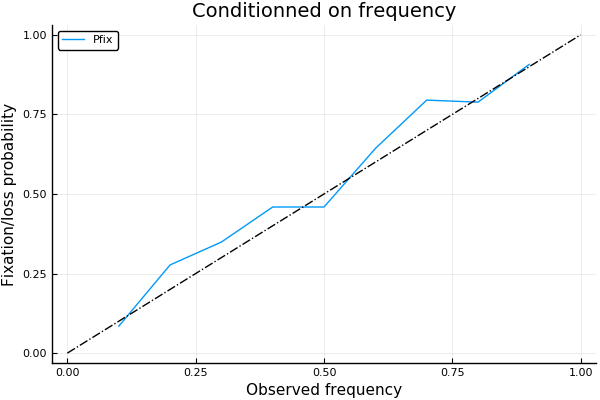

In [53]:
p = plot(xlabel="Observed frequency", ylabel="Fixation/loss probability")
x = zeros(Float64,0); yf = zeros(Float64,0); yl = zeros(Float64,0)
for (α,traj) in freqtraj_cf
    push!(x,α)
    Nfix = length(findall(x->x.fixation==:fixed, traj))
    Nlost = length(findall(x->x.fixation==:lost, traj))
    push!(yf, Nfix / (Nfix + Nlost))
    push!(yl, Nlost / (Nfix + Nlost))
end
tmp = sortperm(x); x = x[tmp]; yl = yl[tmp]; yf = yf[tmp]
plot!(p, x, yf, label="Pfix")
plot!(p, [0, 1], [0, 1], color=:black, linestyle=:dashdot, label="")
plot!(title="Conditionned on frequency")

This is not obvious, is it? 
If dynamics was made of sweeps only, this should be a flat line at 50% 

In [16]:
freqtraj_cdup = Dict()
freqtraj_cddown = Dict()
for α in 0.1:0.1:0.9    
    freqtraj_cdup[α] = FluTools.derivative_condition(ph, α, true, inertia = 2)
    freqtraj_cdup[α] = FluTools.filter_trajectories(freqtraj_cdup[α], duplicate=true, poly=true)[1]
    for traj in freqtraj_cdup[α]
        FluTools.fixation!(traj)
    end
    
    freqtraj_cddown[α] = FluTools.derivative_condition(ph, α, false, inertia = 2)
    freqtraj_cddown[α] = FluTools.filter_trajectories(freqtraj_cddown[α], duplicate=true, poly=true)[1]
    for traj in freqtraj_cddown[α]
        FluTools.fixation!(traj)
    end
end

UndefVarError: UndefVarError: derivative_condition not defined

In [17]:
p = plot(size=(1200,900))
for traj in freqtraj_cdup[0.2]
    if traj.fixation == :fixed
        plot!(getfield.(traj.t, :value), traj.freq, alpha=0.3, color=:blue, label="")
    elseif traj.fixation == :lost
        plot!(getfield.(traj.t, :value), traj.freq, alpha=0.3, color=:red, label="")
    else
        plot!(getfield.(traj.t, :value), traj.freq, alpha=0.3, color=:black, label="")
    end
end
p

KeyError: KeyError: key 0.2 not found

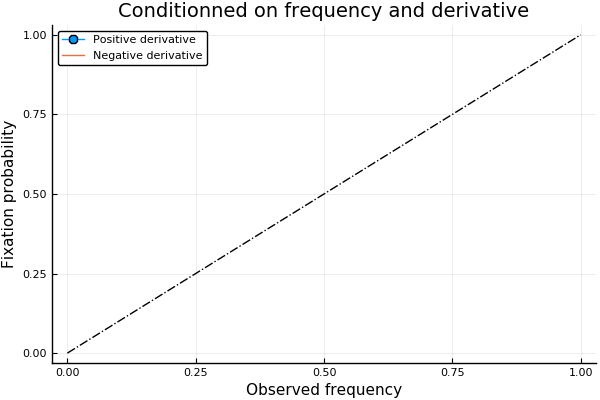

In [18]:
p = plot(xlabel="Observed frequency", ylabel="Fixation probability")
xu = zeros(Float64,0); xd = zeros(Float64,0); yfd = zeros(Float64,0); yld = zeros(Float64,0); yfu = zeros(Float64,0); ylu = zeros(Float64,0); nld = zeros(Float64,0); nlu = zeros(Float64,0); 
for (α,traj) in freqtraj_cddown
    push!(xd,α)
    Nfix = length(findall(x->x.fixation==:fixed, traj))
    Nlost = length(findall(x->x.fixation==:lost, traj))
    push!(yfd, Nfix / (Nfix + Nlost))
    push!(yld, Nlost / (Nfix + Nlost))
    push!(nld, Nfix + Nlost)
end
for (α,traj) in freqtraj_cdup
    push!(xu,α)
    Nfix = length(findall(x->x.fixation==:fixed, traj))
    Nlost = length(findall(x->x.fixation==:lost, traj))
    push!(yfu, Nfix / (Nfix + Nlost))
    push!(ylu, Nlost / (Nfix + Nlost))
    push!(nlu, Nfix + Nlost)
    println()
end
tmp = sortperm(xu); xu = xu[tmp]; ylu = ylu[tmp]; yfu = yfu[tmp]; nlu = nlu[tmp]; 
tmp = sortperm(xd); xd = xd[tmp]; yfd = yfd[tmp]; ylu = ylu[tmp]; nld = nld[tmp];
plot!(p, xu, yfu, label="Positive derivative", marker=:o)
plot!(p, xd, yfd, label="Negative derivative")
plot!(p, [0, 1], [0, 1], color=:black, linestyle=:dashdot, label="")
plot!(title="Conditionned on frequency and derivative")

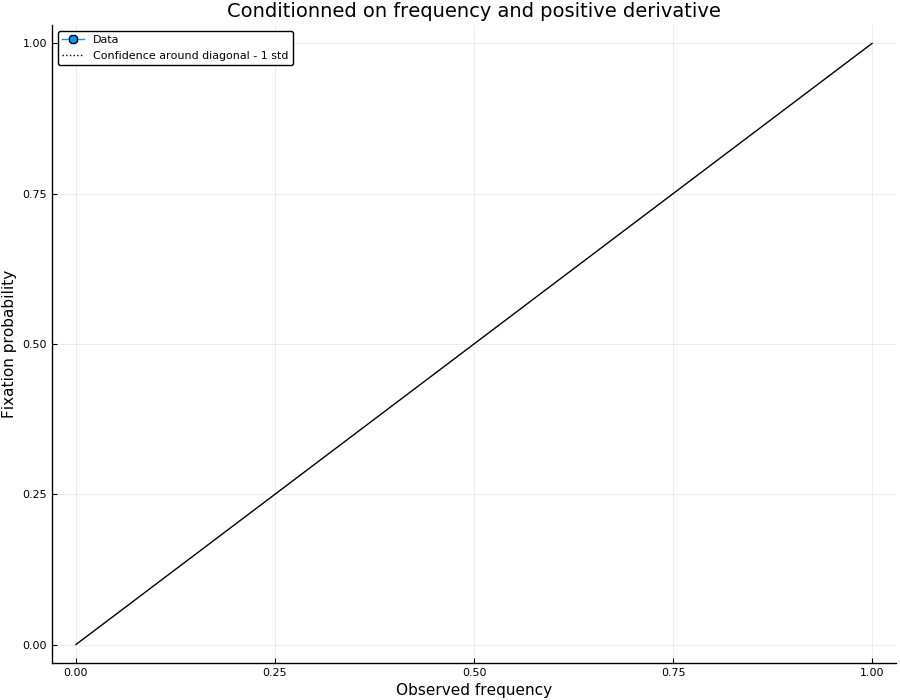

In [19]:
p = plot(xlabel="Observed frequency", ylabel="Fixation probability", size=(900,700))
plot!(p, xu, yfu, label="Data", marker=:o)
plot!(p, [0, 1], [0, 1], color=:black, line=(1,:solid), label="")
plot!(p, xu, xu + sqrt.(xu.*(1 .-xu)./nlu), line=(:black, 1,:dot), label="Confidence around diagonal - 1 std")
plot!(p, xu, xu - sqrt.(xu.*(1 .-xu)./nlu), line=(:black, 1,:dot), label="" )

plot!(title="Conditionned on frequency and positive derivative")

## By regions
NA, Europe, China, JapKor, seem to have enough sequences from 2000 on

In [20]:
bigregions = FluTools.nextstrain_regions[[1,3,4,7]]
# bigregions = FluTools.nextstrain_regions
spr = Dict(r=>FluTools.filterstrainpop(sp, regions=[r]) for r in bigregions)
for (r,s) in spr
    FluTools.bin_by_date!(s, start = Date(2000));
end

In [21]:
freqtraj_up = Dict()
freqtraj_down = Dict()
alpha_values = collect(0.1:0.1:0.9)
for (r,s) in spr
    println(r)
    # History of all positions
    ph = Array{FluTools.PosEvo,1}(undef,L)
    for i in 1:L
        print("$i             \r")
        ph[i] = FluTools.positions_history(i, s)
    end
    # Trajectories
    for α in alpha_values   
        freqtraj_up[r,α] = FluTools.derivative_condition(ph, α, true, inertia = 2)
        freqtraj_up[r,α] = FluTools.filter_trajectories(freqtraj_up[r,α], duplicate=true, poly=true)[1]
        map(x->FluTools.fixation!(x), collect(values(freqtraj_up[r,α])))

        freqtraj_down[r,α] = FluTools.derivative_condition(ph, α, false, inertia = 2)
        freqtraj_down[r,α] = FluTools.filter_trajectories(freqtraj_down[r,α], duplicate=true, poly=true)[1]
        map(x->FluTools.fixation!(x), collect(values(freqtraj_down[r,α])))
    end
end

japan_korea


BoundsError: BoundsError: attempt to access 0-element Array{MyBioTools.FluTools.Strain,1} at index [1]

In [22]:
pdata = Dict()
for r in bigregions
    xu = zeros(Float64,0); xd = zeros(Float64,0); yfu = zeros(Float64,0); yfd = zeros(Float64,0)
    for α in alpha_values
        # Up
        push!(xu, α)
        traj = freqtraj_up[r,α]
        Nfix = length(findall(x->x.fixation==:fixed, traj))
        Nlost = length(findall(x->x.fixation==:lost, traj))
        push!(yfu, Nfix / (Nfix + Nlost))
        # Down
        push!(xd, α)
        traj = freqtraj_down[r,α]
        Nfix = length(findall(x->x.fixation==:fixed, traj))
        Nlost = length(findall(x->x.fixation==:lost, traj))
        push!(yfd, Nfix / (Nfix + Nlost))
    end
    pdata[r] = ((xu, yfu), (xd, yfd))
end

KeyError: KeyError: key ("north_america", 0.1) not found

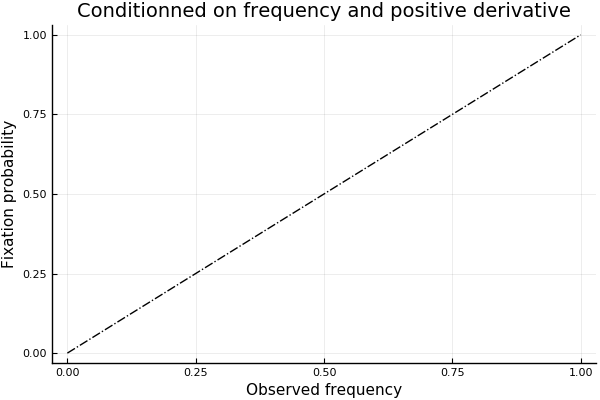

In [23]:
p = plot(xlabel="Observed frequency", ylabel="Fixation probability")
for (r,d) in pdata
    plot!(p, d[1][1], d[1][2], label="$r")
end
plot!(p, [0, 1], [0, 1], color=:black, linestyle=:dashdot, label="")
plot!(title="Conditionned on frequency and positive derivative")
p

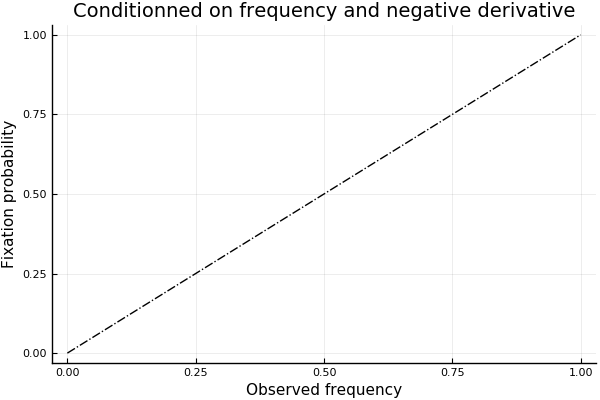

In [24]:
p = plot(xlabel="Observed frequency", ylabel="Fixation probability")
for (r,d) in pdata
    plot!(p, d[2][1], d[2][2], label="$r")
end
plot!(p, [0, 1], [0, 1], color=:black, linestyle=:dashdot, label="")
plot!(title="Conditionned on frequency and negative derivative")
p

In [25]:
r = "europe"; α = 0.3
p = plot(size=(1200,900))
for traj in freqtraj_up[(r, α)]
    if traj.fixation == :fixed
        plot!(getfield.(traj.t, :value), traj.freq, alpha=0.3, color=:blue, label="")
    elseif traj.fixation == :lost
        plot!(getfield.(traj.t, :value), traj.freq, alpha=0.3, color=:red, label="")
    else
        plot!(getfield.(traj.t, :value), traj.freq, alpha=0.3, color=:black, label="")
    end
end
plot!(title = "$r - α=$α")
p

KeyError: KeyError: key ("europe", 0.3) not found

## Cumulative frequency condition

In [26]:
freqtraj_ccf = Dict()
for α in alpha_values
    freqtraj_ccf[α] = cat(FluTools.cumulative_frequency_condition.(ph, α)...,dims=1);
    for traj in freqtraj_ccf[α] 
        FluTools.fixation!(traj)
    end
end

UndefVarError: UndefVarError: cumulative_frequency_condition not defined

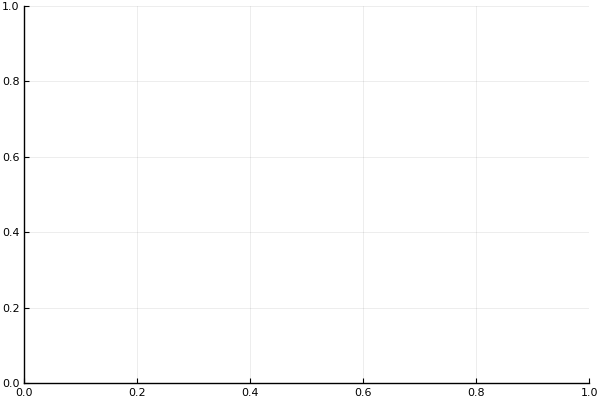

In [27]:
p = plot()
for traj in tmp
    plot!(getfield.(traj.t, :value), traj.freq, label="")
end
p

These are all trajectories that were below 5% in the past and are observed above $\alpha$

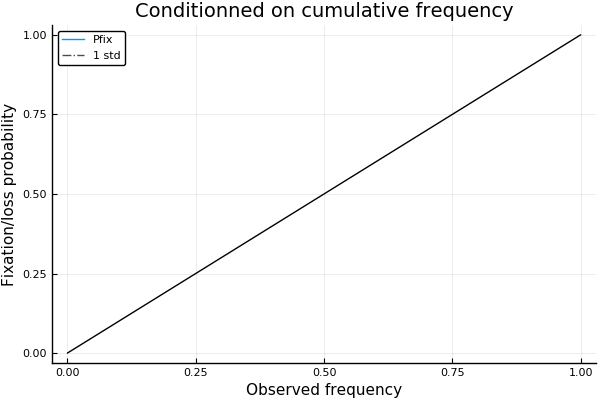

In [28]:
p = plot(xlabel="Observed frequency", ylabel="Fixation/loss probability")
x = zeros(Float64,0); yf = zeros(Float64,0); yl = zeros(Float64,0); n = zeros(Float64,0)
for (α,traj) in freqtraj_ccf
    push!(x,α)
    Nfix = length(findall(x->x.fixation==:fixed, traj))
    Nlost = length(findall(x->x.fixation==:lost, traj))
    push!(yf, Nfix / (Nfix + Nlost))
    push!(yl, Nlost / (Nfix + Nlost))
    push!(n, Nfix+Nlost)
end
tmp = sortperm(x); x = x[tmp]; yl = yl[tmp]; yf = yf[tmp]; n = n[tmp]
plot!(p, x, yf, label="Pfix")
plot!(p, x, x + sqrt.(x.*(1 .-x)./n), label="1 std", line=(0.7,:black,:dashdot))
plot!(p, x, x - sqrt.(x.*(1 .-x)./n), label="", line=(0.7,:black,:dashdot))
plot!(p, [0, 1], [0, 1], color=:black, linestyle=:solid, label="")
plot!(title="Conditionned on cumulative frequency")

## Previous state + frequency condition

In [29]:
freqtraj_cps = Dict()
for α in alpha_values
    freqtraj_cps[α] = cat(FluTools.previous_state_condition.(ph, α, :lost)...,dims=1);
    for traj in freqtraj_cps[α] 
        FluTools.fixation!(traj)
    end
end

UndefRefError: UndefRefError: access to undefined reference

In [30]:
α=0.2
p = plot(title="alpha=$(α)")
for traj in freqtraj_cps[α]
    plot!(getfield.(traj.t, :value), traj.freq, label="")
end
p

KeyError: KeyError: key 0.2 not found

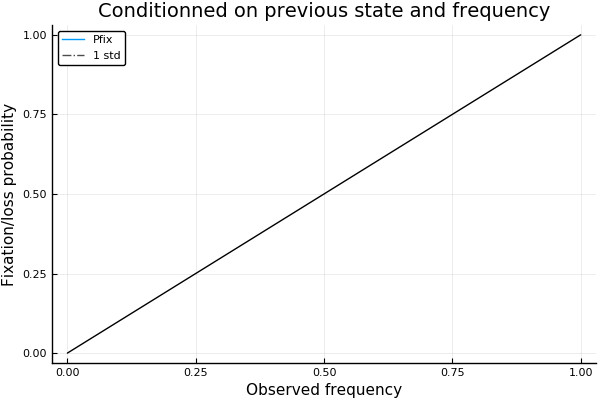

In [31]:
p = plot(xlabel="Observed frequency", ylabel="Fixation/loss probability")
x = zeros(Float64,0); yf = zeros(Float64,0); yl = zeros(Float64,0); n = zeros(Float64,0)
for (α,traj) in freqtraj_cps
    push!(x,α)
    Nfix = length(findall(x->x.fixation==:fixed, traj))
    Nlost = length(findall(x->x.fixation==:lost, traj))
    push!(yf, Nfix / (Nfix + Nlost))
    push!(yl, Nlost / (Nfix + Nlost))
    push!(n, Nfix+Nlost)
end
tmp = sortperm(x); x = x[tmp]; yl = yl[tmp]; yf = yf[tmp]; n = n[tmp]
plot!(p, x, yf, label="Pfix")
plot!(p, x, x + sqrt.(x.*(1 .-x)./n), label="1 std", line=(0.7,:black,:dashdot))
plot!(p, x, x - sqrt.(x.*(1 .-x)./n), label="", line=(0.7,:black,:dashdot))
plot!(p, [0, 1], [0, 1], color=:black, linestyle=:solid, label="")
plot!(title="Conditionned on previous state and frequency")

In [32]:
ph[1].alphabet

UndefRefError: UndefRefError: access to undefined reference

## Neutral mutations: Positions with unchanged AA

### Conditionned on frequency

In [33]:
# History of all positions
ph = Array{FluTools.PosEvo,1}(undef,L)
for i in 1:L
    print("$i       \r")
    ph[i] = FluTools.positions_history(i, sp)
end

In [34]:
cst_pos = findall(x->length(x.alphabet)==1, ph);

In [35]:
freqtraj_codon_cf = Dict()
for α in 0.1:0.1:0.9
    freqtraj_codon_cf[α] = FluTools.frequency_condition(ph[cst_pos], α, filter_duplicates=true, codon=true);
    for traj in freqtraj_codon_cf[α]
        FluTools.fixation!(traj)
    end
end

MethodError: MethodError: no method matching frequency_condition(::Array{MyBioTools.FluTools.PosEvo,1}, ::Float64; filter_duplicates=true, codon=true)
Closest candidates are:
  frequency_condition(!Matched::Array{MyBioTools.FluTools.FrequencyTraj,1}, ::Any; dα, shift_time) at /home/pierrebc/Documents/BaleLabo/Code/MyTools/MyBioTools/src/FluTools/trajectories.jl:85 got unsupported keyword arguments "filter_duplicates", "codon"

In [36]:
p = plot(size=(1200,900))
α = 0.6
for (i,traj) in enumerate(freqtraj_codon_cf[α])
    FluTools.fixation!(traj)
    if traj.fixation == :fixed 
        plot!(getfield.(traj.t, :value), traj.freq, alpha=0.1, color=:blue, label="")
    elseif traj.fixation == :lost 
        plot!(getfield.(traj.t, :value), traj.freq, alpha=0.1, color=:red, label="")
    end
end
plot!(p, [-200, 200], [α - 0.05, α - 0.05], color=:black)
plot!(p, [-200, 200], [α + 0.05, α + 0.05], color=:black)
p

KeyError: KeyError: key 0.6 not found

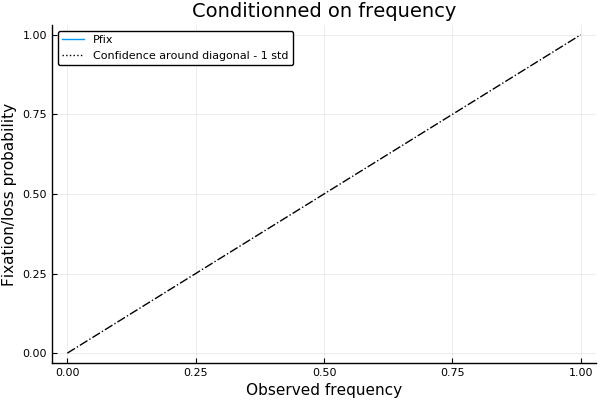

In [37]:
p = plot(xlabel="Observed frequency", ylabel="Fixation/loss probability")
x = zeros(Float64,0); yf = zeros(Float64,0); yl = zeros(Float64,0); n = zeros(Float64,0)
for (α,traj) in freqtraj_codon_cf
    push!(x,α)
    Nfix = length(findall(x->x.fixation==:fixed, traj))
    Nlost = length(findall(x->x.fixation==:lost, traj))
    push!(yf, Nfix / (Nfix + Nlost))
    push!(yl, Nlost / (Nfix + Nlost))
    push!(n, Nfix + Nlost)
end
tmp = sortperm(x); x = x[tmp]; yl = yl[tmp]; yf = yf[tmp]; n = n[tmp]
plot!(p, x, yf, label="Pfix")
plot!(p, [0, 1], [0, 1], color=:black, linestyle=:dashdot, label="")
plot!(p, x, x + sqrt.(x.*(1 .-x)./n), line=(:black, 1,:dot), label="Confidence around diagonal - 1 std")
plot!(p, x, x - sqrt.(x.*(1 .-x)./n), line=(:black, 1,:dot), label="" )
plot!(title="Conditionned on frequency")

### Conditionned on lower bound frequency

In [38]:
alpha_values = collect(0.1:0.1:0.9)
freqtraj_codon_ccf = Dict()
for α in alpha_values
    freqtraj_codon_ccf[α] = cat(FluTools.cumulative_frequency_condition.(ph, α, codon=true)...,dims=1);
    for traj in freqtraj_codon_ccf[α] 
        FluTools.fixation!(traj)
    end
end

UndefVarError: UndefVarError: cumulative_frequency_condition not defined

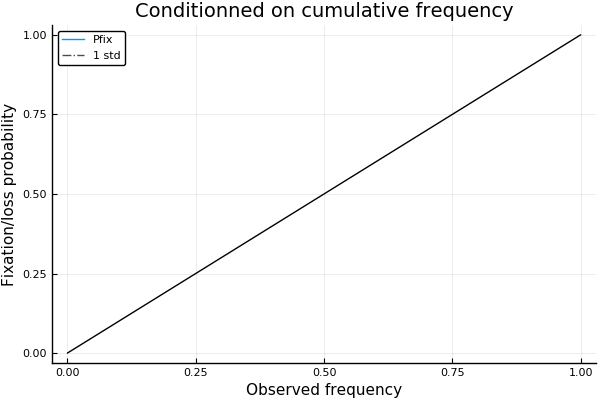

In [39]:
p = plot(xlabel="Observed frequency", ylabel="Fixation/loss probability")
x = zeros(Float64,0); yf = zeros(Float64,0); yl = zeros(Float64,0); n = zeros(Float64,0)
for (α,traj) in freqtraj_codon_ccf
    push!(x,α)
    Nfix = length(findall(x->x.fixation==:fixed, traj))
    Nlost = length(findall(x->x.fixation==:lost, traj))
    push!(yf, Nfix / (Nfix + Nlost))
    push!(yl, Nlost / (Nfix + Nlost))
    push!(n, Nfix+Nlost)
end
tmp = sortperm(x); x = x[tmp]; yl = yl[tmp]; yf = yf[tmp]; n = n[tmp]
plot!(p, x, yf, label="Pfix")
plot!(p, x, x + sqrt.(x.*(1 .-x)./n), label="1 std", line=(0.7,:black,:dashdot))
plot!(p, x, x - sqrt.(x.*(1 .-x)./n), label="", line=(0.7,:black,:dashdot))
plot!(p, [0, 1], [0, 1], color=:black, linestyle=:solid, label="")
plot!(title="Conditionned on cumulative frequency")

## Persistence of trajectories

In [40]:
propagator_cf = Dict()
propagator_cd_plus = Dict()
propagator_cd_minus = Dict()
alpha_values = collect(0.1:0.1:0.9)
for α in alpha_values
    propagator_cf[α] = FluTools.propagator_frequency_condition(ph, α, nbins=90, binwidth=Day(61), dα=0.05);
    propagator_cd_plus[α] = FluTools.propagator_derivative_condition(ph, α, nbins=90, binwidth=Day(61), derivative=true, inertia=1);
    propagator_cd_minus[α] = FluTools.propagator_derivative_condition(ph, α, nbins=90, binwidth=Day(61), derivative=false, inertia=1);
end

UndefVarError: UndefVarError: propagator_frequency_condition not defined

In [41]:
function plotdict(d; func=mean)
    t = [x.value for x in keys(d)]
    y = [func(x) for x in values(d)]
    n = [length(x) for x in values(d)]
    tmp = sortperm(t)
    t = t[tmp]; y = y[tmp]; n = n[tmp]
    return t,y,n
end

plotdict (generic function with 1 method)

In [42]:
p = plot()
for α in alpha_values
    x,y,n = plotdict(propagator_cf[α])
    plot!(p, x, y, label="$α")
#     plot!(p, x, y + sqrt.(y.*(1 .-y)./n), label="", line=(0.5,:black,:dashdot))
#     plot!(p, x, y - sqrt.(y.*(1 .-y)./n), label="", line=(0.7,:black,:dashdot))
end
p

KeyError: KeyError: key 0.1 not found

In [43]:
p = plot(ylim=(-1,2))
αeq = 0.39
for α in alpha_values
    x,y,n = plotdict(propagator_cf[α])
    plot!(p, x, (y .- α)/(αeq - α), label="$α")
end
p

KeyError: KeyError: key 0.1 not found

In [44]:
pd = Dict()
for α in alpha_values
    p = plot(title="α = $α", size=(900,650), ylim=(0,1))
    x,y,n = plotdict(propagator_cf[α])
    plot!(p, x, y, label="Conditionned on frequency")
#     plot!(p, x, y + sqrt.(y.*(1 .-y)./n), line=(0.6,:black,:dashdot), label="")
#     plot!(p, x, y - sqrt.(y.*(1 .-y)./n), line=(0.6,:black,:dashdot), label="")
    x,y,n = plotdict(propagator_cd_plus[α])
    plot!(p, x, y, label="Conditionned on positive derivative")
    x,y,n = plotdict(propagator_cd_minus[α])
    plot!(p, x, y, label="Conditionned on negative derivative")
#     display(p);
    pd[α] = p
end
plot(cat([x for x in [pd[y] for y in sort(collect(keys(pd)))]], plot(),dims=1)..., layout=(5,2), size=(900,1500))

KeyError: KeyError: key 0.1 not found

In [45]:
out = FluTools.derivative_propagator_frequency_condition(ph, 0.1, nbins=90, binwidth=Day(61));

UndefVarError: UndefVarError: derivative_propagator_frequency_condition not defined

In [46]:
x,y,n = plotdict(out)
plot(x,y)

UndefVarError: UndefVarError: out not defined

In [47]:
mean(y)

UndefVarError: UndefVarError: y not defined

In [48]:
dpropagator_cf = Dict()
dpropagator_cd_plus = Dict()
dpropagator_cd_minus = Dict()
alpha_values = collect(0.1:0.1:0.9)
for α in alpha_values
    dpropagator_cf[α] = FluTools.derivative_propagator_frequency_condition(ph, α, nbins=30, binwidth=Day(61), dα=0.05);
    dpropagator_cd_plus[α] = FluTools.derivative_propagator_derivative_condition(ph, α, nbins=30, binwidth=Day(61), derivative=true, inertia=1);
    dpropagator_cd_minus[α] = FluTools.derivative_propagator_derivative_condition(ph, α, nbins=30, binwidth=Day(61), derivative=false, inertia=1);
end

UndefVarError: UndefVarError: derivative_propagator_frequency_condition not defined

In [49]:
pd = Dict()
for α in alpha_values
    p = plot(title="α = $α", size=(900,650), ylim=(-.1,.1))
    x,y,n = plotdict(dpropagator_cf[α])
    plot!(p, x, y, label="Conditionned on frequency")
#     plot!(p, x, y + sqrt.(y.*(1 .-y)./n), line=(0.6,:black,:dashdot), label="")
#     plot!(p, x, y - sqrt.(y.*(1 .-y)./n), line=(0.6,:black,:dashdot), label="")
    x,y,n = plotdict(dpropagator_cd_plus[α])
    plot!(p, x, y, label="Conditionned on positive derivative")
    x,y,n = plotdict(dpropagator_cd_minus[α])
    plot!(p, x, y, label="Conditionned on negative derivative")
#     display(p);
    pd[α] = p
end
plot(cat([x for x in [pd[y] for y in sort(collect(keys(pd)))]], plot(),dims=1)..., layout=(5,2), size=(900,1500))

KeyError: KeyError: key 0.1 not found

In [50]:
timebins = [i*bw for i in 0:10] .- Day(round(Int64, bw.value/2))
out = FluTools.derivative_autocorrelation(traj, timebins)

UndefVarError: UndefVarError: bw not defined

In [51]:
freqtraj_cf = Dict()
for α in 0.1:0.1:0.9
    freqtraj_cf[α] = FluTools.frequency_condition(ph, α, filter_duplicates=false);
end

MethodError: MethodError: no method matching frequency_condition(::Array{MyBioTools.FluTools.PosEvo,1}, ::Float64; filter_duplicates=false)
Closest candidates are:
  frequency_condition(!Matched::Array{MyBioTools.FluTools.FrequencyTraj,1}, ::Any; dα, shift_time) at /home/pierrebc/Documents/BaleLabo/Code/MyTools/MyBioTools/src/FluTools/trajectories.jl:85 got unsupported keyword argument "filter_duplicates"

In [52]:
ac

UndefVarError: UndefVarError: ac not defined

In [53]:
p = plot(xlabel="Days", ylabel="Autocorr", size=(900,700))
for α in alpha_values
    bw = Day(61)
    timebins = [i*bw for i in 0:10] .- Day(round(Int64, bw.value/2))
    ac = sum(FluTools.derivative_autocorrelation(traj, timebins) for traj in freqtraj_cf[α]);
    plot!(p, [x.value for x in timebins[1:end-1]] .+ round(Int64, bw.value/2), ac[:,1]./(ac[:,1] + ac[:,2]), marker=:o, label="$α")
end
p

KeyError: KeyError: key 0.1 not found

In [54]:
x,y,z = FluTools.frequency_plot(ph[1])

(Date[1995-03-02, 1995-05-01, 1995-07-01, 1995-08-31, 1995-11-01, 1995-12-31, 1996-03-01, 1996-05-01, 1996-07-01, 1996-08-31  …  2017-05-01, 2017-07-01, 2017-08-31, 2017-11-01, 2017-12-31, 2018-03-02, 2018-05-01, 2018-07-01, 2018-08-31, 2018-11-01], [1.0; 1.0; … ; 1.0; 1.0], [40, 7, 2, 6, 17, 23, 16, 9, 8, 15  …  2151, 1977, 2287, 2403, 2881, 2458, 1184, 541, 609, 1010])

In [55]:
typeof(y)

Array{Float64,2}

In [56]:
for posh in ph
    

LoadError: syntax: incomplete: premature end of input